# Building a Recurrent Language Model for Natural Language Generation

__Elliott Forney - 2020__

This notebook demonstrates how to use a simple unidirectional language model to generate artificial natural language text.  To make things a bit more interesting, we will actually train our network over Shakespeare plays and generate artificial Shakespeare-style text.  In practice, however, any large corpus could be used for training this type of language model.

In [143]:
import random, re

import nltk
import matplotlib.pyplot as plt
import munch
import torch as th

%matplotlib inline

The NLTK library provides a few packaged as the "Gutenberg Corpora" that we can leverage for training our language model.

In [15]:
nltk.download('gutenberg');

[nltk_data] Downloading package gutenberg to /home/idfah/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In particular, we will use the Shakespeare plays of Caesar, Hamlet and Macbeth, 

In [3]:
nltk.corpus.gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [4]:
filenames = [filename for filename in nltk.corpus.gutenberg.fileids() if filename.startswith('shakespeare')]
filenames

['shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt']

Next, we will combine all of these documents into a single `list(list(list(str)))` that is segmented by paragraph, then sentence, then word.

In [5]:
paras_by_sentence = sum((list(nltk.corpus.gutenberg.paras(filename)) for filename in filenames), [])
paras_by_sentence[4]

[['Mur', '.'],
 ['Where', 'is', 'thy', 'Leather', 'Apron', ',', 'and', 'thy', 'Rule', '?'],
 ['What', 'dost', 'thou', 'with', 'thy', 'best', 'Apparrell', 'on', '?'],
 ['You', 'sir', ',', 'what', 'Trade', 'are', 'you', '?'],
 ['Cobl', '.'],
 ['Truely',
  'Sir',
  ',',
  'in',
  'respect',
  'of',
  'a',
  'fine',
  'Workman',
  ',',
  'I',
  'am',
  'but',
  'as',
  'you',
  'would',
  'say',
  ',',
  'a',
  'Cobler']]

Since we are interested in natural language generation, we would like our model to be able to model cross-sentence information.  So, we will instead combine all sentences in each paragraph to yield a `list(list(str))` that is segmented by paragraphs and then words.

We also convert all text to lower case, which will help to reduce the size of the vocabulary in this corpus, which is desirable because this corpus is actually somewhat small.

In [16]:
paras = [sum(sentence, []) for sentence in paras_by_sentence]
paras = [[word.lower() for word in para] for para in paras]
paras[4]

['mur',
 '.',
 'where',
 'is',
 'thy',
 'leather',
 'apron',
 ',',
 'and',
 'thy',
 'rule',
 '?',
 'what',
 'dost',
 'thou',
 'with',
 'thy',
 'best',
 'apparrell',
 'on',
 '?',
 'you',
 'sir',
 ',',
 'what',
 'trade',
 'are',
 'you',
 '?',
 'cobl',
 '.',
 'truely',
 'sir',
 ',',
 'in',
 'respect',
 'of',
 'a',
 'fine',
 'workman',
 ',',
 'i',
 'am',
 'but',
 'as',
 'you',
 'would',
 'say',
 ',',
 'a',
 'cobler']

Also, it appears that some paragraphs have no ending punctuation.  So, we add a trailing `.` token for paragraphs that end with a word.

We also remove any paragraphs that don't have at least three word tokens.  Note that at least two word-tokens are required for the modeling procedure below because we will be continually predicting the next word.  Using a minimum length of three ensures that even after predicting the next token, we will never have predictions with a length of only one.

In [20]:
word_regex = re.compile(r'\w')
min_para_len = 3

def ending_punct(words):
    if word_regex.match(words[-1]):
        return words + ['.']
    return words

paras = [ending_punct(para) for para in paras if len(para) > min_para_len]
paras[4]

['mur',
 '.',
 'where',
 'is',
 'thy',
 'leather',
 'apron',
 ',',
 'and',
 'thy',
 'rule',
 '?',
 'what',
 'dost',
 'thou',
 'with',
 'thy',
 'best',
 'apparrell',
 'on',
 '?',
 'you',
 'sir',
 ',',
 'what',
 'trade',
 'are',
 'you',
 '?',
 'cobl',
 '.',
 'truely',
 'sir',
 ',',
 'in',
 'respect',
 'of',
 'a',
 'fine',
 'workman',
 ',',
 'i',
 'am',
 'but',
 'as',
 'you',
 'would',
 'say',
 ',',
 'a',
 'cobler',
 '.']

Next, we implement a simple class that will hold an indexed vocabulary for all words in our corpus.  This `IndexVocab` maps string words to integer indices that correspond to columns in a word embedding matrix.

In [24]:
class IndexVocab(dict):
    '''An indexed vocabulary maps string to a column index in a word embedding.
    '''
    # special words and their indices
    pad, unk = '<pad>', '<unk>'
    pad_idx, unk_idx = 0, 1
    
    def __init__(self, paras):
        '''Initialize a new `IndexedVocab` from a `list(list(str))` of paragraphs
        that are segmented by words.
        '''
        words = sorted(list(set(word for para in paras for word in para)))
        words = [self.pad, self.unk] + words
        super().__init__({word: idx for idx, word in enumerate(words)})
        
    def get(self, word, default=unk_idx):
        '''Get the integer index of a string word, return `unk_idx` if the word
        is not in the vocab.
        '''
        return super().get(word, default)

In [26]:
vocab = IndexVocab(paras)
vocab.get('cask'), vocab.get('junk')

(996, 1)

Next, we print some basic statistics about our corpus and its vocabulary.

In [28]:
print('nparas:', len(paras))
print('nwords:', sum(len(para) for para in paras))
print('max_para_len:', max(len(para) for para in paras))
print('vocab_len:', len(vocab))

nparas: 2183
nwords: 87601
max_para_len: 596
vocab_len: 7551


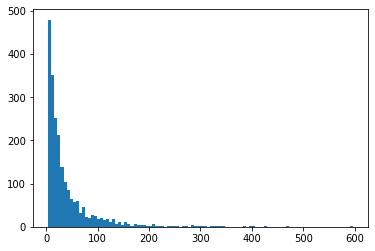

In [29]:
plt.hist(list(map(len, paras)), bins=100);

In [110]:
class Data:
    def __init__(self, paras, vocab):        
        self.vocab = vocab
      
        paras = sorted(paras, key=list.__len__, reverse=True)
        self.para_idxs = [[self.vocab.get(word) for word in para] for para in paras]

    def __getitem__(self, i):
        para_idxs = self.para_idxs[i] if isinstance(i, slice) else [self.para_idxs[i],]
        
        lens = th.as_tensor(list(map(len, para_idxs)), dtype=th.int64)
        
        idxs = th.nn.utils.rnn.pad_sequence(                                                        
            [th.as_tensor(idxs, dtype=th.int64) for idxs in para_idxs],                  
            padding_value=IndexVocab.pad_idx)
        
        return idxs, lens
    
    def __len__(self):
        return len(self.para_idxs)
    
    def batch_generator(self, batch_size, shuffle=True):
        batch_starts = list(range(0, len(self), batch_size))
        
        if shuffle:
            random.shuffle(batch_starts)
        
        for start in batch_starts:
            yield self[start:(start+batch_size)]

In [111]:
random.shuffle(paras)

train_data = Data(paras[:-100], vocab)
valid_data = Data(paras[-100:], vocab)

train_data[0:5]

(tensor([[2963, 2963, 3750, 4005, 3583],
         [   9,    9,    9,    9,    9],
         [3292, 4443, 4302, 2820, 6571],
         ...,
         [6576,    0,    0,    0,    0],
         [3583,    0,    0,    0,    0],
         [   9,    0,    0,    0,    0]]), tensor([596, 469, 402, 397, 386]))

In [112]:
for i, (idxs, lens) in enumerate(train_data.batch_generator(128, shuffle=False)):
    print(i, idxs.shape, lens.shape)

0 torch.Size([596, 128]) torch.Size([128])
1 torch.Size([123, 128]) torch.Size([128])
2 torch.Size([85, 128]) torch.Size([128])
3 torch.Size([60, 128]) torch.Size([128])
4 torch.Size([47, 128]) torch.Size([128])
5 torch.Size([37, 128]) torch.Size([128])
6 torch.Size([31, 128]) torch.Size([128])
7 torch.Size([26, 128]) torch.Size([128])
8 torch.Size([22, 128]) torch.Size([128])
9 torch.Size([19, 128]) torch.Size([128])
10 torch.Size([16, 128]) torch.Size([128])
11 torch.Size([13, 128]) torch.Size([128])
12 torch.Size([11, 128]) torch.Size([128])
13 torch.Size([9, 128]) torch.Size([128])
14 torch.Size([8, 128]) torch.Size([128])
15 torch.Size([7, 128]) torch.Size([128])
16 torch.Size([4, 35]) torch.Size([35])


In [129]:
class LanguageModel(th.nn.Module):
    def __init__(self, embed_dim, nhidden, vocab_size):
        super().__init__()
        
        self.embed_dim = embed_dim
        self.nhidden = nhidden
        self.vocab_size = vocab_size
        
        self.embed = th.nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim=self.embed_dim,
            padding_idx=IndexVocab.pad_idx)
        
        self.hidden = th.nn.RNN(input_size=self.embed_dim, hidden_size=self.nhidden)
        self.visible = th.nn.Linear(in_features=self.nhidden, out_features=self.vocab_size)
        self.softmax = th.nn.Softmax(dim=0)
        
    def forward(self, idxs, lens):
        assert idxs.ndim == 2
        max_len = idxs.shape[0]
        batch_size = idxs.shape[1]
        
        assert lens.ndim == 1
        assert lens.shape[0] == batch_size
        
        word_vectors = self.embed(idxs)
        
        assert word_vectors.ndim == 3
        assert word_vectors.shape[0] == max_len
        assert word_vectors.shape[1] == batch_size
        assert word_vectors.shape[2] == self.embed_dim
        
        packed_word_vectors = th.nn.utils.rnn.pack_padded_sequence(
            word_vectors, lens, enforce_sorted=True)
        
        packed_hidden_out, _ = self.hidden(packed_word_vectors)
        hidden_out, _ = th.nn.utils.rnn.pad_packed_sequence(packed_hidden_out)
        
        assert hidden_out.ndim == 3
        assert hidden_out.shape[0] == max_len
        assert hidden_out.shape[1] == batch_size
        assert hidden_out.shape[2] == self.nhidden
        
        visible_out = self.visible(hidden_out)
        assert visible_out.ndim == 3
        assert visible_out.shape[0] == max_len
        assert visible_out.shape[1] == batch_size
        assert visible_out.shape[2] == self.vocab_size
        
        return visible_out

In [134]:
lm = LanguageModel(embed_dim=16, nhidden=16, vocab_size=len(vocab))

for i, (idxs, lens) in enumerate(train_data.batch_generator(64, shuffle=False)):
    idxs_in = idxs[:-1]
    idxs_out = idxs[1:]
    print(idxs_in.shape, idxs_out.shape, lens.shape)
    
    print(lm(idxs_in, lens - 1).shape)

torch.Size([595, 64]) torch.Size([595, 64]) torch.Size([64])
torch.Size([595, 64, 7551])
torch.Size([169, 64]) torch.Size([169, 64]) torch.Size([64])
torch.Size([169, 64, 7551])
torch.Size([122, 64]) torch.Size([122, 64]) torch.Size([64])
torch.Size([122, 64, 7551])
torch.Size([99, 64]) torch.Size([99, 64]) torch.Size([64])
torch.Size([99, 64, 7551])
torch.Size([84, 64]) torch.Size([84, 64]) torch.Size([64])
torch.Size([84, 64, 7551])
torch.Size([71, 64]) torch.Size([71, 64]) torch.Size([64])
torch.Size([71, 64, 7551])
torch.Size([59, 64]) torch.Size([59, 64]) torch.Size([64])
torch.Size([59, 64, 7551])
torch.Size([53, 64]) torch.Size([53, 64]) torch.Size([64])
torch.Size([53, 64, 7551])
torch.Size([46, 64]) torch.Size([46, 64]) torch.Size([64])
torch.Size([46, 64, 7551])
torch.Size([41, 64]) torch.Size([41, 64]) torch.Size([64])
torch.Size([41, 64, 7551])
torch.Size([36, 64]) torch.Size([36, 64]) torch.Size([64])
torch.Size([36, 64, 7551])
torch.Size([33, 64]) torch.Size([33, 64]) tor

In [160]:
def train(model, train_data, valid_data, epochs=30, batch_size=32, shuffle=True,
          learning_rate=0.0015):
    model.train()
    model.cuda()
    
    loss_func = th.nn.CrossEntropyLoss(ignore_index=IndexVocab.pad_idx, reduction='mean')
    optimizer = th.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    valid_losses = []
    
    for epoch in range(epochs):
        train_batch_generator = train_data.batch_generator(batch_size=batch_size, shuffle=shuffle)
        print('=' * 14 + f'epoch {epoch}' + '=' * 14)
        
        cur_train_loss = 0.0
        for batch, (idxs, lens) in enumerate(train_batch_generator):
            optimizer.zero_grad()
            
            idxs = idxs.cuda()
            lens = lens.cuda()

            idxs_in, idxs_out = idxs[:-1], idxs[1:]
            
            pred_idxs = model(idxs_in, lens - 1)
            loss = loss_func(pred_idxs.reshape(-1, pred_idxs.shape[-1]), idxs_out.reshape(-1))
            
            cur_train_loss += loss.item()
            print('t', batch, loss.item())

            loss.backward()
            optimizer.step()
            
        train_losses.append(cur_train_loss / batch)
        
        valid_batch_generator = valid_data.batch_generator(batch_size=batch_size, shuffle=shuffle)
        
        cur_valid_loss = 0.0
        for batch, (idxs, lens) in enumerate(valid_batch_generator):
            idxs = idxs.cuda()
            lens = lens.cuda()
            
            idxs_in, idxs_out = idxs[:-1], idxs[1:]
            
            pred_idxs = model(idxs_in, lens - 1)
            loss = loss_func(pred_idxs.reshape(-1, pred_idxs.shape[-1]), idxs_out.reshape(-1))
            
            cur_valid_loss += loss.item()
            print('v', batch, loss.item())
            
        valid_losses.append(cur_valid_loss / batch)
            

    model.cpu()
    model.eval()
    
    return munch.munchify({
        'model': model,
        'train_losses': train_losses,
        'valid_losses': valid_losses,
    })

In [165]:
lm = LanguageModel(embed_dim=32, nhidden=64, vocab_size=len(vocab))

train_result = train(lm, train_data, valid_data, epochs=30)

==============epoch 0==============
t 0 8.968165397644043
t 1 8.9631929397583
t 2 8.945843696594238
t 3 8.918925285339355
t 4 8.888428688049316
t 5 8.88371753692627
t 6 8.881804466247559
t 7 8.861421585083008
t 8 8.808341979980469
t 9 8.785506248474121
t 10 8.752714157104492
t 11 8.701920509338379
t 12 8.652649879455566
t 13 8.626296997070312
t 14 8.545282363891602
t 15 8.445302963256836
t 16 8.344369888305664
t 17 8.212394714355469
t 18 8.072517395019531
t 19 7.95790433883667
t 20 7.8559675216674805
t 21 7.679100036621094
t 22 7.855388641357422
t 23 7.406538009643555
t 24 7.354397296905518
t 25 7.421950817108154
t 26 7.148069381713867
t 27 7.084894180297852
t 28 6.882006645202637
t 29 6.901636600494385
t 30 6.782920837402344
t 31 6.76918888092041
t 32 6.802661895751953
t 33 6.575845718383789
t 34 6.554752826690674
t 35 6.4287214279174805
t 36 6.386997222900391
t 37 6.447911262512207
t 38 6.727334499359131
t 39 6.301543235778809
t 40 6.460125923156738
t 41 6.423182487487793
t 42 6.1814

t 5 5.134555339813232
t 6 5.461808681488037
t 7 6.028757572174072
t 8 5.5719146728515625
t 9 4.451596736907959
t 10 5.1569366455078125
t 11 5.568588733673096
t 12 5.721248626708984
t 13 6.063140869140625
t 14 5.944977283477783
t 15 5.520042419433594
t 16 5.510200023651123
t 17 4.519819259643555
t 18 4.335965156555176
t 19 4.998626232147217
t 20 5.601045608520508
t 21 5.560423851013184
t 22 5.834313869476318
t 23 4.22524881362915
t 24 5.9473795890808105
t 25 5.330713272094727
t 26 4.745423316955566
t 27 4.942884922027588
t 28 4.987980842590332
t 29 4.369660377502441
t 30 5.494807243347168
t 31 5.736331939697266
t 32 5.557256698608398
t 33 3.444849729537964
t 34 5.662986755371094
t 35 6.0548095703125
t 36 5.244264125823975
t 37 4.5046706199646
t 38 6.051428318023682
t 39 4.960346698760986
t 40 6.192080020904541
t 41 6.247936248779297
t 42 4.751018047332764
t 43 5.387155532836914
t 44 5.109942436218262
t 45 4.873189926147461
t 46 4.674553394317627
t 47 4.8393378257751465
t 48 3.8494732379

t 23 5.6943359375
t 24 5.065374851226807
t 25 4.369985580444336
t 26 4.390387058258057
t 27 2.173109292984009
t 28 5.951632022857666
t 29 4.211644649505615
t 30 5.562647342681885
t 31 4.249553203582764
t 32 4.455655574798584
t 33 5.167120933532715
t 34 5.553023815155029
t 35 4.5733160972595215
t 36 3.772484064102173
t 37 5.836199760437012
t 38 3.425283432006836
t 39 3.9052629470825195
t 40 5.642658710479736
t 41 4.426540851593018
t 42 4.477178573608398
t 43 5.1927337646484375
t 44 5.084810256958008
t 45 4.806336879730225
t 46 5.105698108673096
t 47 3.911733388900757
t 48 5.043091773986816
t 49 5.323507785797119
t 50 5.085448265075684
t 51 3.71879506111145
t 52 4.912973403930664
t 53 5.260557651519775
t 54 5.101172924041748
t 55 3.9618237018585205
t 56 5.475431442260742
t 57 4.388126850128174
t 58 4.335198402404785
t 59 5.484852313995361
t 60 4.973416328430176
t 61 4.922628879547119
t 62 4.598073959350586
t 63 4.986355781555176
t 64 5.269503593444824
t 65 5.585522651672363
v 0 5.3984460

t 25 3.56003737449646
t 26 4.806260585784912
t 27 5.807013511657715
t 28 4.3326616287231445
t 29 5.042368412017822
t 30 4.021274566650391
t 31 4.723692893981934
t 32 4.441346645355225
t 33 4.708693027496338
t 34 4.0465826988220215
t 35 3.503262758255005
t 36 5.348730087280273
t 37 3.4995460510253906
t 38 4.896200180053711
t 39 4.591752052307129
t 40 5.207869529724121
t 41 5.612327575683594
t 42 5.375209331512451
t 43 3.997819185256958
t 44 4.7981486320495605
t 45 3.585132598876953
t 46 4.81156587600708
t 47 4.790934085845947
t 48 4.709787368774414
t 49 4.897398471832275
t 50 4.784566402435303
t 51 3.4123785495758057
t 52 4.165676593780518
t 53 3.0436878204345703
t 54 4.930638790130615
t 55 4.717390060424805
t 56 3.874095916748047
t 57 5.21478796005249
t 58 3.867358446121216
t 59 3.3195602893829346
t 60 5.041618347167969
t 61 5.575519561767578
t 62 5.453747749328613
t 63 4.551888942718506
t 64 4.283355236053467
t 65 3.420437812805176
v 0 3.312091827392578
v 1 4.232381343841553
v 2 5.307

t 35 2.195154905319214
t 36 3.6072323322296143
t 37 4.437193393707275
t 38 2.997325897216797
t 39 2.9737017154693604
t 40 4.2388153076171875
t 41 3.5384507179260254
t 42 2.9390480518341064
t 43 4.025400638580322
t 44 4.5814433097839355
t 45 5.159609317779541
t 46 5.113933563232422
t 47 5.079294204711914
t 48 3.774887800216675
t 49 3.827077627182007
t 50 4.792952060699463
t 51 4.061549663543701
t 52 4.469443321228027
t 53 3.2473084926605225
t 54 3.056791067123413
t 55 4.548863887786865
t 56 4.566851615905762
t 57 4.672832489013672
t 58 3.7692203521728516
t 59 4.699759483337402
t 60 0.9732537865638733
t 61 5.009330749511719
t 62 5.456165313720703
t 63 4.554371356964111
t 64 3.5525758266448975
t 65 4.8086347579956055
v 0 2.953793525695801
v 1 4.192617416381836
v 2 5.922721862792969
v 3 5.272821426391602
==============epoch 21==============
t 0 3.9679343700408936
t 1 4.637372016906738
t 2 2.8555359840393066
t 3 3.6075615882873535
t 4 4.355499267578125
t 5 5.062016010284424
t 6 4.1589698791

t 39 4.428765296936035
t 40 4.833366394042969
t 41 4.4518842697143555
t 42 3.812973976135254
t 43 4.192899227142334
t 44 3.7874157428741455
t 45 4.336431980133057
t 46 5.278222560882568
t 47 4.234483242034912
t 48 4.570163249969482
t 49 2.848890542984009
t 50 4.808588981628418
t 51 3.271697998046875
t 52 3.4681968688964844
t 53 3.345637559890747
t 54 2.761841297149658
t 55 4.171571254730225
t 56 2.9528725147247314
t 57 5.140204906463623
t 58 0.6378918290138245
t 59 4.9465107917785645
t 60 2.3954715728759766
t 61 4.529743194580078
t 62 3.0347440242767334
t 63 2.471853017807007
t 64 4.9623870849609375
t 65 3.728351354598999
v 0 4.138404846191406
v 1 5.999207019805908
v 2 2.6789603233337402
v 3 5.3144426345825195
==============epoch 26==============
t 0 3.738060712814331
t 1 3.1838607788085938
t 2 5.112008094787598
t 3 4.274310111999512
t 4 4.080301284790039
t 5 3.6591084003448486
t 6 3.4477322101593018
t 7 4.505107879638672
t 8 3.701338768005371
t 9 2.8976802825927734
t 10 4.378937721252

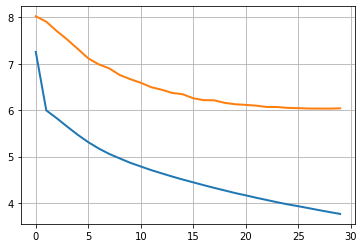

In [167]:
plt.plot(train_result.train_losses, linewidth=2, label='Train');
plt.plot(train_result.valid_losses, linewidth=2, label='Validation');
plt.grid()